In [ ]:
# from onc_dts import SILSDK_DTS

In [1]:
from onc_dts import read_xt_file, plot_dts_data
from pathlib import Path

%load_ext autoreload
%autoreload 2

In [21]:
data_dir = Path("../../onc_dts_py_driver/notebooks/data/")
xt_files = list(data_dir.glob('instrument_files/*/*.xt'))

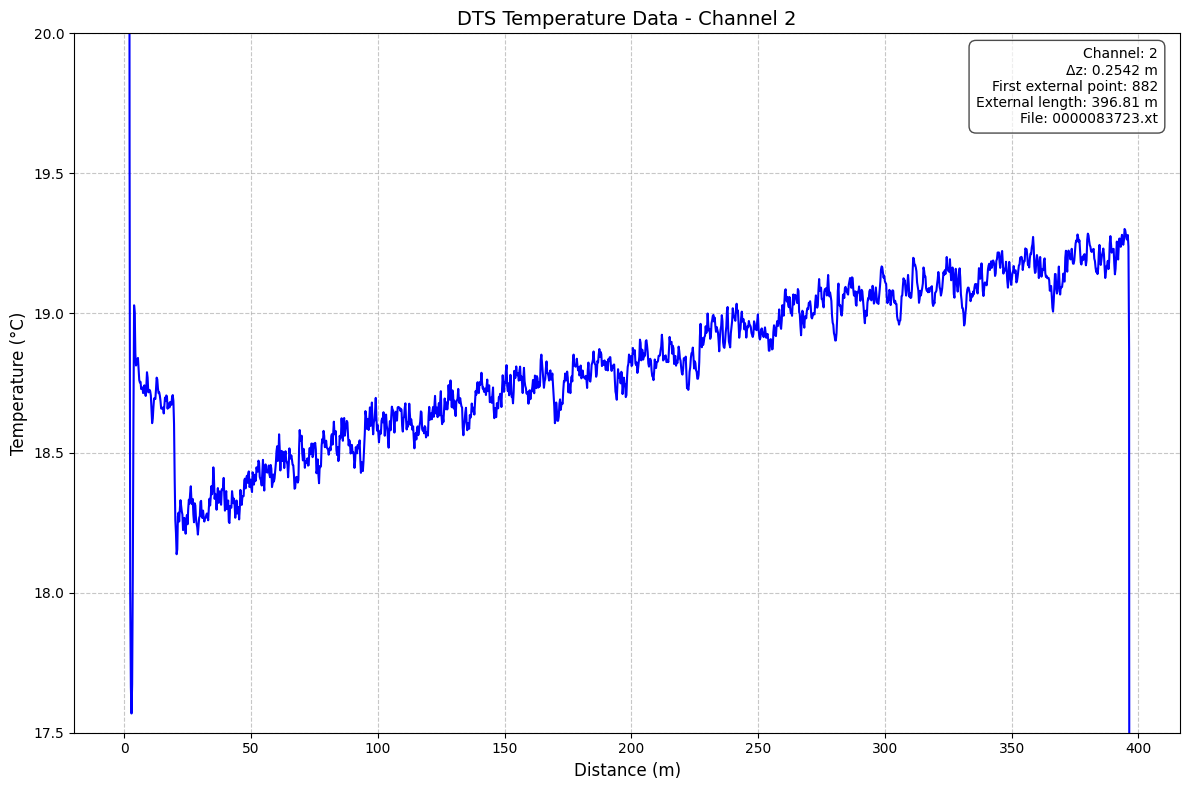

{'metadata': {'channel': 2,
  'dz': 0.25419927587844254,
  'first_external_point': 882,
  'filename': '0000083723.xt',
  'datetime': None,
  'n_external_points': 1561,
  'external_length': 396.8050696462488,
  'total_length': 621.0088309710351},
 'temp_data': array([28.900208, 30.016205, 30.588654, ..., 19.237457, 18.872528,
        13.370148], shape=(1561,), dtype=float32),
 'distance': array([0.00000000e+00, 2.54199276e-01, 5.08398552e-01, ...,
        3.96042472e+02, 3.96296671e+02, 3.96550870e+02], shape=(1561,))}

In [28]:
file_data = read_xt_file(xt_files[-2], trim=True)
plot_dts_data(file_data, include_raw=False, temp_range=(17.5, 20))

file_data

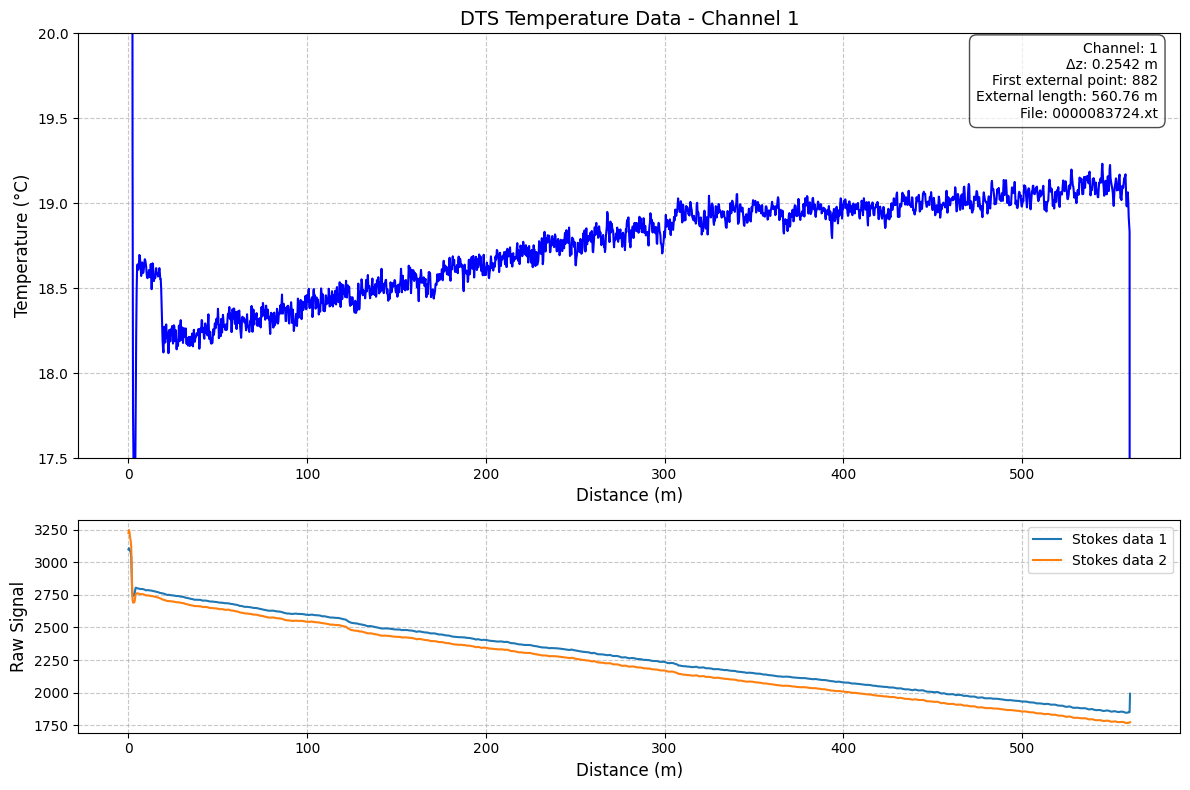

{'metadata': {'channel': 1,
  'dz': 0.25419927587844254,
  'first_external_point': 882,
  'filename': '0000083724.xt',
  'datetime': None,
  'n_external_points': 2206,
  'external_length': 560.7636025878443,
  'total_length': 784.9673639126306},
 'temp_data': array([28.537506 , 29.33786  , 29.234589 , ..., 18.878662 , 18.83142  ,
         6.5791016], shape=(2206,), dtype=float32),
 'distance': array([0.00000000e+00, 2.54199276e-01, 5.08398552e-01, ...,
        5.60001005e+02, 5.60255204e+02, 5.60509403e+02], shape=(2206,)),
 'raw_data': {'forward': array([[ 3.1090172e-02, -6.3301988e-02, -1.6572668e-01, ...,
          -6.6952393e+01, -5.6711998e+00, -1.0138438e+01],
         [ 1.7847285e-02,  3.8680437e-01, -7.8743435e-02, ...,
          -3.5877560e+01, -3.1050472e+01,  5.6939545e+00]],
        shape=(2, 3103), dtype=float32),
  'reverse': array([], dtype=float32)}}

In [29]:
file_data = read_xt_file(xt_files[-1], include_raw=True)
plot_dts_data(file_data, include_raw=True, temp_range=(17.5, 20))
file_data

## Next Figure out xarray

In [ ]:
import json
from base64 import b64decode
from typing import Dict, Any, Union, Optional, List, Tuple

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [110]:
datetimes = []
dat_arrays = []

with open('../data/DTS_getChannelDataResponse_no_heat.txt', 'r') as f:
    for line in f:
        line_parts = line.split(', ')
        
        record = json.loads(''.join(line_parts[1:]))
        datetime_str = line_parts[0].split(' ')[0]
        n_samples = record['Info']['Current Temperature Signal']['Dim'][0]
        dat = np.frombuffer(b64decode(record['Info']['Current Temperature Signal']['Data']), dtype='<f4')
        dat_arrays.append(dat-273.15)  # Convert to Celsius
        datetimes.append(datetime_str)

z0 = record['Info']['Current Temperature Signal']['z0']
dz = record['Info']['Current Temperature Signal']['dz']
z0_external = record['Info']['Current Temperature Signal']['z0 external']
first_external_point = record['Info']['Current Temperature Signal']['first external point']
z = np.arange(z0, z0 + (n_samples+1 * dz), dz)[:n_samples]


In [107]:
#n_samples, z0, z, np.array(dat_arrays)

In [111]:
datetimes = pd.to_datetime(datetimes, format='%Y%m%dT%H%M%S.%fZ')
temp_arr = xr.DataArray(
    data=np.array(dat_arrays),
    dims=['time', 'depth'],
    coords={
        'time': xr.DataArray(datetimes, dims='time'),
        'depth': xr.DataArray(z, dims='depth')
    },
    attrs={
        'units': 'C',
        'description': 'Temperature profile from DTS'
    }
)

In [56]:
temp_arr

<xarray.DataArray (time: 1000, depth: 8945)> Size: 36MB
array([[   0.      ,    0.      ,    0.      , ...,    0.      ,
         172.42477 ,  978.027   ],
       [   0.      ,    0.      ,    0.      , ...,    0.      ,
          45.833496,  180.91406 ],
       [   0.      ,    0.      ,    0.      , ..., -163.22746 ,
          72.71216 ,  199.54861 ],
       ...,
       [   0.      ,    0.      ,    0.      , ...,  -34.328613,
         133.18546 ,    0.      ],
       [   0.      ,    0.      ,    0.      , ...,  -37.03055 ,
          65.569305,    0.      ],
       [   0.      ,    0.      ,    0.      , ...,  -44.894882,
         -13.720398,    0.      ]], shape=(1000, 8945), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8kB 2025-04-09T17:22:17.238000 ... 2025-04...
  * depth    (depth) float64 72kB -224.0 -223.7 -223.5 ... 2.049e+03 2.05e+03
Attributes:
    units:        C
    description:  Temperature profile from DTS

In [112]:
temp_arr.loc[:,0:1000].quantile(0.99)

<xarray.DataArray ()> Size: 8B
array(25.6340332)
Coordinates:
    quantile  float64 8B 0.99

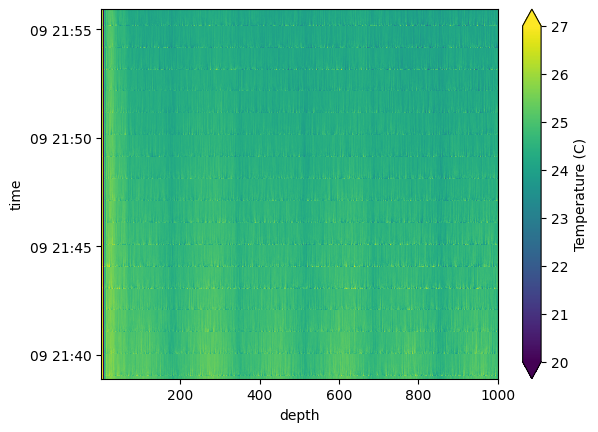

In [113]:
temp_arr.loc[:,0:1000].plot(vmin=20, vmax=27, cmap='viridis', cbar_kwargs={'label': 'Temperature (C)'})

Text(0.5, 0, 'External Distance (m)')

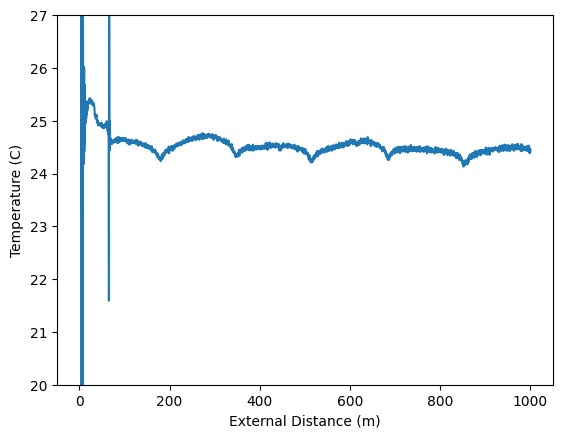

In [114]:
temp_arr.loc[:,0:1000].mean(dim='time').plot(ylim=(20,27))
plt.ylabel('Temperature (C)')
plt.xlabel('External Distance (m)')

## Old stuff


In [ ]:
def read_xt_file(file_path: Union[str, Path], include_raw: bool = False, channel_points = {1: 2206, 2: 1561}) -> Dict[str, Any]:
    """Reads and parses a .xt file, extracting temperature data and metadata.
    
    This function opens a .xt file (JSON format), extracts temperature data,
    distance information, raw signals, and metadata from the file.
    
    Args:
        file_path: Path to the .xt file as string or Path object
        
    Returns:
        A dictionary containing:
            temp_data: Temperature data array (in Celsius)
            distance: Distance array (in meters)
            raw_data: Raw signal data (if available)
            metadata: Dictionary of metadata from the file
            full_json: The complete parsed JSON data
            
    Raises:
        FileNotFoundError: If the specified file does not exist
        json.JSONDecodeError: If the file is not valid JSON
    """
    # Ensure file_path is a Path object
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    
    # Read and parse the JSON data
    with open(file_path, 'r') as f:
        json_data = json.load(f)
    
    out = {}
    # Extract metadata from the JSON file
    metadata = {
        'channel': json_data['processed data'].get('forward channel', 0) + 1,
        'dz': json_data['processed data']['resampled temperature data']['dz'],
        'first_external_point': json_data['processed data']['resampled temperature data']['first external point'],
        'filename': file_path.name,
        'datetime': json_data.get('date time', None),
        # 'device_info': json_data.get('device info', {})
    }
    metadata['n_external_points'] = channel_points[metadata['channel']]
    metadata['external_length'] = metadata['n_external_points'] * metadata['dz']
    metadata['total_length'] = metadata['external_length'] +metadata['first_external_point'] * metadata['dz']
    out['metadata'] = metadata
    
    
    # Extract temperature data and convert from Kelvin to Celsius
    temp_data = np.frombuffer(
        b64decode(json_data['processed data']['resampled temperature data']['signal']['Data']), 
        dtype='<f4'
    ) - 273.15  # Convert from K to °C
    
    # Calculate the distance array based on first external point
    pt_from = metadata['first_external_point']
    pt_to = pt_from + channel_points[metadata['channel']]
    distance = (np.arange(pt_from, pt_to) - pt_from) * metadata['dz']
    
    out['temp_data'] = temp_data[pt_from:pt_to]
    out['distance'] = distance
    
    if include_raw:
        # Extract raw data if available
        raw_data: Dict[str, np.ndarray] = {}
        
        # Process forward raw data if present
        if 'resampled forward raw data' in json_data['processed data']:
            raw_fwd = np.frombuffer(
                b64decode(json_data['processed data']['resampled forward raw data']['signal']['Data']), 
                dtype='<f4'
            )
            # Reshape if necessary - typically for multi-channel data
            if len(raw_fwd) > len(temp_data):
                # Determine number of channels from the JSON or use default of 2
                channels = json_data['processed data'].get('number of channels', 2)
                raw_fwd = raw_fwd.reshape(channels, -1)
            raw_data['forward'] = raw_fwd
        
        # Process reverse raw data if present    
        if 'resampled reverse raw data' in json_data['processed data']:
            raw_rev = np.frombuffer(
                b64decode(json_data['processed data']['resampled reverse raw data']['signal']['Data']), 
                dtype='<f4'
            )
            # Reshape if necessary and maintain consistent shape with forward data
            if len(raw_rev) > len(distance) and 'forward' in raw_data:
                raw_rev = raw_rev.reshape(raw_data['forward'].shape[0], -1)
            raw_data['reverse'] = raw_rev
        out['raw_data'] = raw_data    
        
    # Return structured dictionary with all extracted information
    return out

In [ ]:
def plot_dts_data(file_data: Dict[str, Any], 
                  include_raw: bool = False, 
                  figsize: Tuple[int, int] = (12, 8),
                  temp_range: Optional[Tuple[float, float]] = None,
                  save_path: Optional[Union[str, Path]] = None) -> None:
    """Creates comprehensive visualization of DTS data.
    
    This function creates publication-quality plots of the DTS temperature
    data, with options to include raw signal data and customize the appearance.
    
    Args:
        file_data: Dictionary containing DTS data as returned by read_xt_file()
        include_raw: Whether to plot raw signal data in addition to temperature
        figsize: Width and height of the figure in inches
        temp_range: Optional temperature range as (min, max) in Celsius
        save_path: Optional path to save the figure
        
    Returns:
        None: The function creates and displays the plot
    """
    # Extract relevant data from the file_data dictionary
    temp_data = file_data['temp_data']
    distance = file_data['distance']
    metadata = file_data['metadata']
    
    # Create figure with appropriate layout based on include_raw
    if include_raw and 'raw_data' in file_data and file_data['raw_data']:
        fig, axs = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [2, 1]})
        temp_ax, raw_ax = axs
    else:
        fig, temp_ax = plt.subplots(figsize=figsize)
        
    # Plot temperature data
    temp_line = temp_ax.plot(distance, temp_data, 'b-', linewidth=1.5)
    
    # Set title and labels with metadata information
    title = f"DTS Temperature Data - Channel {metadata['channel']}"
    if 'datetime' in metadata and metadata['datetime']:
        title += f" ({metadata['datetime']})"
    
    temp_ax.set_title(title, fontsize=14)
    temp_ax.set_xlabel('Distance (m)', fontsize=12)
    temp_ax.set_ylabel('Temperature (°C)', fontsize=12)
    
    # Add temperature range if specified
    if temp_range:
        temp_ax.set_ylim(temp_range)
    
    # Add grid and metadata annotations
    temp_ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add metadata text box
    metadata_text = (
        f"Channel: {metadata['channel']}\n"
        f"Δz: {metadata['dz']:.4f} m\n"
        f"First external point: {metadata['first_external_point']}\n"
        f"External length: {metadata.get('external_length', distance[-1]):.2f} m\n"
        f"File: {metadata['filename']}"
    )
    
    # Position the text box in the top right corner
    temp_ax.text(0.98, 0.98, metadata_text, transform=temp_ax.transAxes,
                fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))
    
    # Plot raw data if requested and available
    if include_raw and 'raw_data' in file_data and file_data['raw_data']:
        raw_data = file_data['raw_data']
        
        if 'forward' in raw_data:
            # Check dimensionality of raw data
            raw_fwd = raw_data['forward']
            if raw_fwd.ndim > 1:
                # For multi-channel raw data
                for i in range(raw_fwd.shape[0]):
                    # Ensure we have enough data to plot
                    start_idx = metadata['first_external_point']
                    end_idx = start_idx + len(distance)
                    
                    # Check if we have enough data points
                    if end_idx <= raw_fwd.shape[1]:
                        raw_ax.plot(distance, raw_fwd[i, start_idx:end_idx],
                                  label=f'Stokes data {i+1}')
            else:
                # For single-channel raw data
                start_idx = metadata['first_external_point']
                end_idx = start_idx + len(distance)
                
                # Check if we have enough data points
                if end_idx <= len(raw_fwd):
                    raw_ax.plot(distance, raw_fwd[start_idx:end_idx],
                              label='Forward')
                
        if 'reverse' in raw_data:
            raw_rev = raw_data['reverse']
            if raw_rev.ndim > 1:
                # For multi-channel raw data
                for i in range(raw_rev.shape[0]):
                    # Ensure we have enough data to plot
                    start_idx = metadata['first_external_point']
                    end_idx = start_idx + len(distance)
                    
                    # Check if we have enough data points
                    if end_idx <= raw_rev.shape[1]:
                        raw_ax.plot(distance, raw_rev[i, start_idx:end_idx],
                                  label=f'Channel {i+1} (rev)', linestyle='--')
            else:
                # For single-channel raw data
                start_idx = metadata['first_external_point']
                end_idx = start_idx + len(distance)
                
                # Check if we have enough data points
                if end_idx <= len(raw_rev):
                    raw_ax.plot(distance, raw_rev[start_idx:end_idx],
                              label='Reverse', linestyle='--')
        
        raw_ax.set_xlabel('Distance (m)', fontsize=12)
        raw_ax.set_ylabel('Raw Signal', fontsize=12)
        raw_ax.grid(True, linestyle='--', alpha=0.7)
        raw_ax.legend(loc='best')
    
    # Adjust layout for better appearance
    fig.tight_layout()
    
    # Save figure if a path is provided
    if save_path:
        save_path = Path(save_path) if not isinstance(save_path, Path) else save_path
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    # Display the plot
    plt.show()